##  Age-structured SIR model for India with social distancing

In example-4 we ran the age-structured SIR model for India with the parameter $\beta$ fitted to case data. We can now examine the effect of interventions, **for an idealised best-case**. We assume that lockdown **instantaneously** and **completely** removes all social contacts from the spheres of workplace, schools, and others. The contact matrix, then, is time-dependent, whose form we take to be
$$
C_{ij}(t) = C_{ij} + u(t)(C^W_{ij} + C^S_{ij} + C^O_{ij}) 
$$
where $u(t)$ is a control function given by
$$
u(t) = \frac{1}{2}\left[\tanh\left(\frac{t-t_{\text{on}}}{t_w}\right)-\tanh\left(\frac{t-t_{\text{off}}}{t_w}\right)\right]
$$
This function has three parameters: the time at which the social distancing is implemented, $t_{\text on}$, the time at which it is lifted $t_{\text {off}}$ and the **lag** between implementation and compliance $t_w$. In the best-case scenario, we assume that this lag is less than day, or in other words, the lockdown acts  **instantaneously**. The function $u(t)$ is one in  window $t_{\text on} \leq t \leq t_{\text{off}}$ and zero outside. We can multiply this by a scale factor $0\leq \epsilon \leq 1$ as a measure of the efficacy of the social distancing. The value $\epsilon =1$ reflects complete compliance; the value $\epsilon=0$ reflects zero compliance. In the best-scenario, we assume  $\epsilon =1$ so there is no scale factor in the control function. 

We now numerically integrate as before, imposing controls of 21 days duration and lifting it afterwards. We also explore various other scenarios, with several periods of lockdown separated by periods of relaxation. The goal is to reduce the number of infectives. In the language of optimal control, our cost function is the number of infectives. We find that the 21 day lockdown will not reduce the number of infectives to a point where explicit contact tracing will be feasible. We take the number 10 to represent a point where social contact tracing may be feasible. This is dependent on region and the effectiveness with which such measures can be implemented. We find a longer lockdowns are needed to bring the number of infectives down to that level. 

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
## population and age classes
M=16  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

In [4]:
# contact matrices
my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_home_1.xlsx', sheet_name='India',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_work_1.xlsx', sheet_name='India',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_school_1.xlsx', sheet_name='India',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_other_locations_1.xlsx', sheet_name='India',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_all_locations_1.xlsx', sheet_name='India',index_col=None)
CA = np.array(my_data)
C=CH+CW+CS+CO

### One closure

In [5]:
beta  = 0.01646692       # contact rate parameter
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.              # asymptomatic fraction
fsa   = 1               # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=3;  Is_0[2:6]=1
Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.deterministic.SIR(parameters, M, Ni)


# the contact matrix is time-dependent
def contactMatrix(t):
    if t<21:
        xx = C
    elif 21<=t<42:
        xx = CH
    else:
        xx = C
    return xx


# start simulation
Tf=98;  Nf=2000 
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

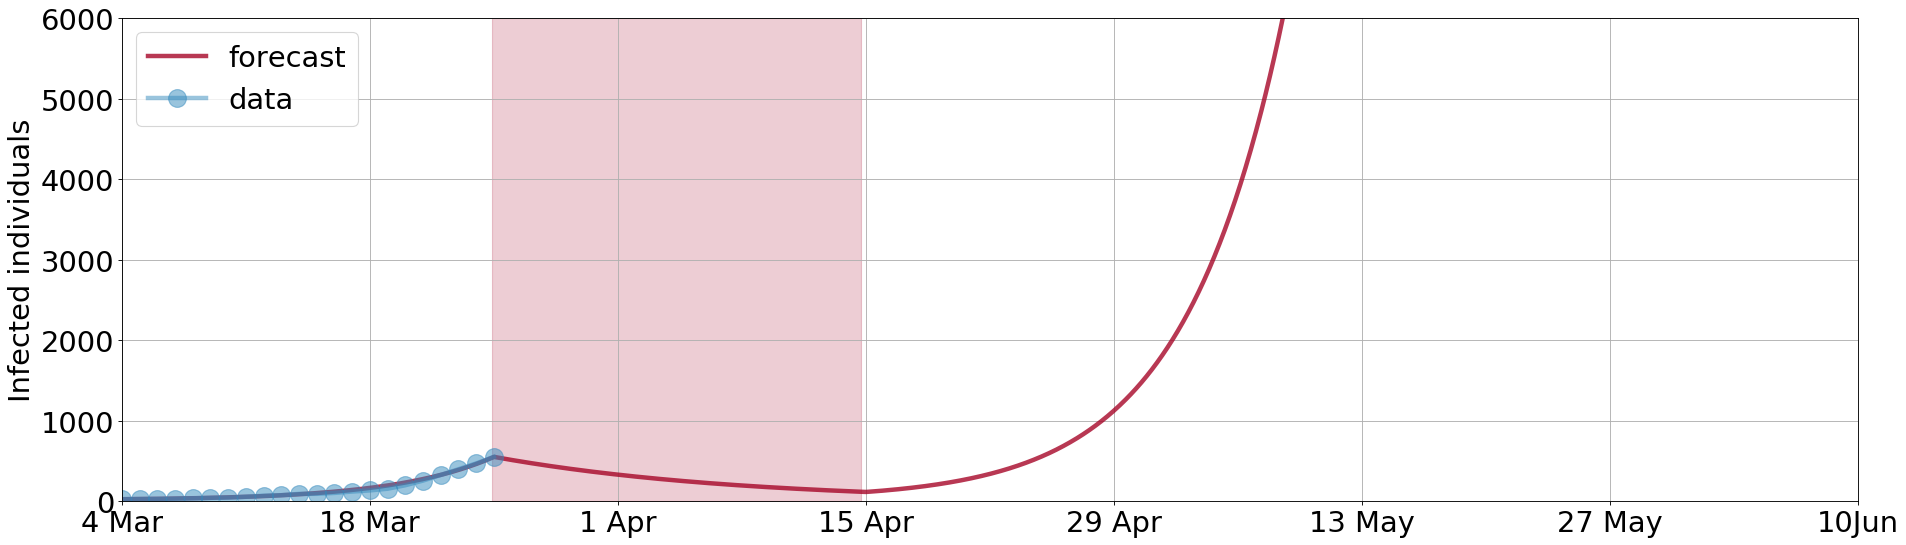

In [6]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']; t1=int(Nf/(14))

fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));
plt.fill_between(t[3*t1:6*t1], 0, 6000, color="#A60628", alpha=0.2)

my_data = np.genfromtxt('../data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,3] - my_data[:,1]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.ylim(0, 6000); plt.xlim(0, 98);
plt.savefig('/Users/rsingh/Desktop/4a.png', format='png', dpi=200)

In [7]:
MM = np.array((0,0,.0,1,1,1,1,1,1,3.5,3.5,3.5,3.5,6,6,14.2))  
## Fatality Rate by AGE per 100 cases https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/
m1 = .01*MM*(data['X'][430,0:M]-data['X'][-1,0:M])
np.sum(m1)

33919.02449917527

### Two closures

In [8]:
def contactMatrix(t):
    if t<21:
        xx = C
    elif 21<=t<42:
        xx = CH
    elif 42<=t<47:
        xx = C
    elif 47<=t<75:
        xx = CH
    else:
        xx = C
    return xx

# start simulation
Tf=98;  Nf=2000 
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

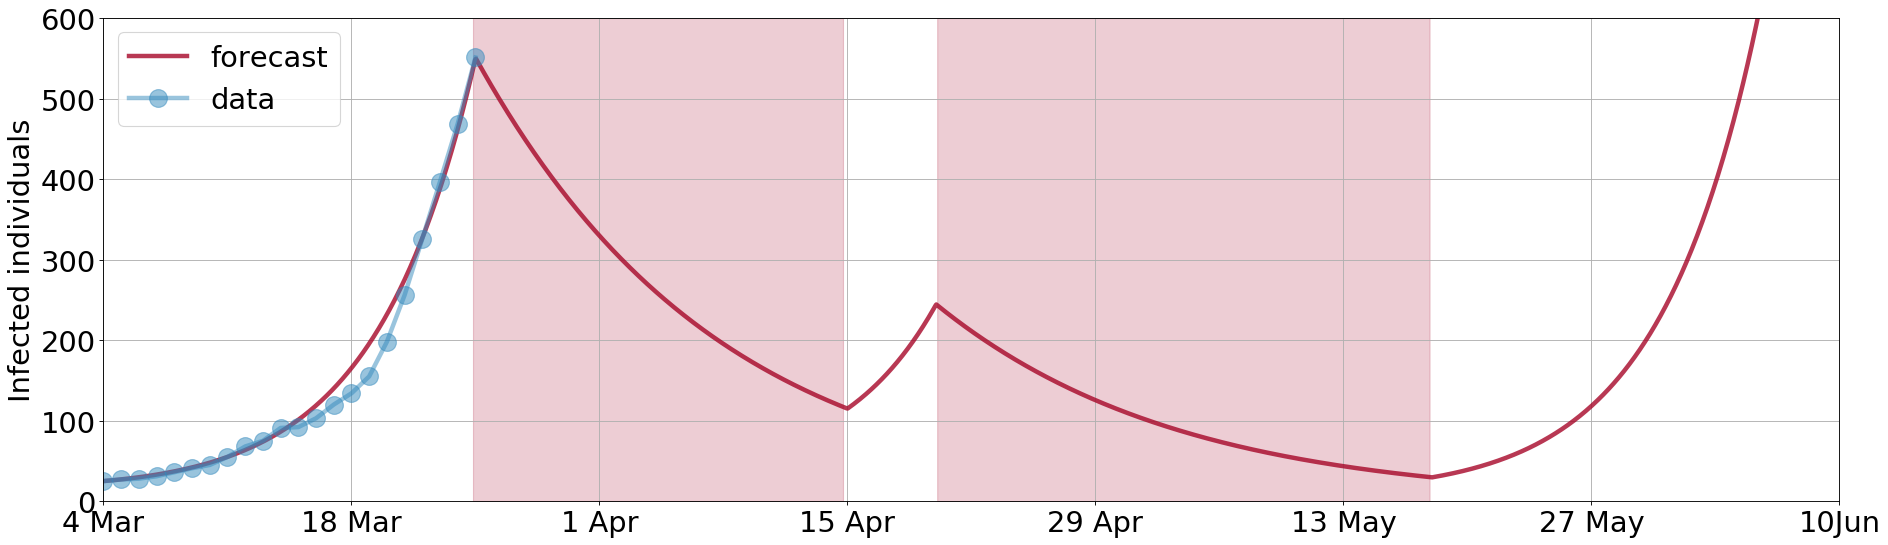

In [9]:
IC  = np.zeros((Nf))
SC  = np.zeros((Nf))

for i in range(M):
        IC += data['X'][:,2*M+i] 
        SC += data['X'][:,0*M+i] 
t = data['t']; t1=int(Nf/(14))


fig=plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));

plt.fill_between(t[3*t1:6*t1], 0, 600, color="#A60628", alpha=0.2)
plt.fill_between(t[6*t1+108:10*t1+108], 0, 600, color="#A60628", alpha=0.2)

my_data = np.genfromtxt('../data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,3] - my_data[:,1]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, Tf); plt.ylim(0, 600);
plt.savefig('/Users/rsingh/Desktop/4b.png', format='png', dpi=200)

In [10]:
MM = np.array((0,0,.0,1,1,1,1,1,1,3.5,3.5,3.5,3.5,6,6,14.2))  
## Fatality Rate by AGE per 100 cases https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/
m1 = .01*MM*(data['X'][430,0:M]-data['X'][-1,0:M])
np.sum(m1)

34.97139382296428

## Three closures

In [11]:
def contactMatrix(t):
    if t<21:
        xx = C
    elif 21<=t<42:
        xx = CH
    elif 42<=t<47:
        xx = C
    elif 47<=t<75:
        xx = CH
    elif 75<=t<80:
        xx = C
    elif 80<=t<98:
        xx = CH
    else:
        xx = CH
    return xx


# start simulation
Tf=98;  Nf=2000;  
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

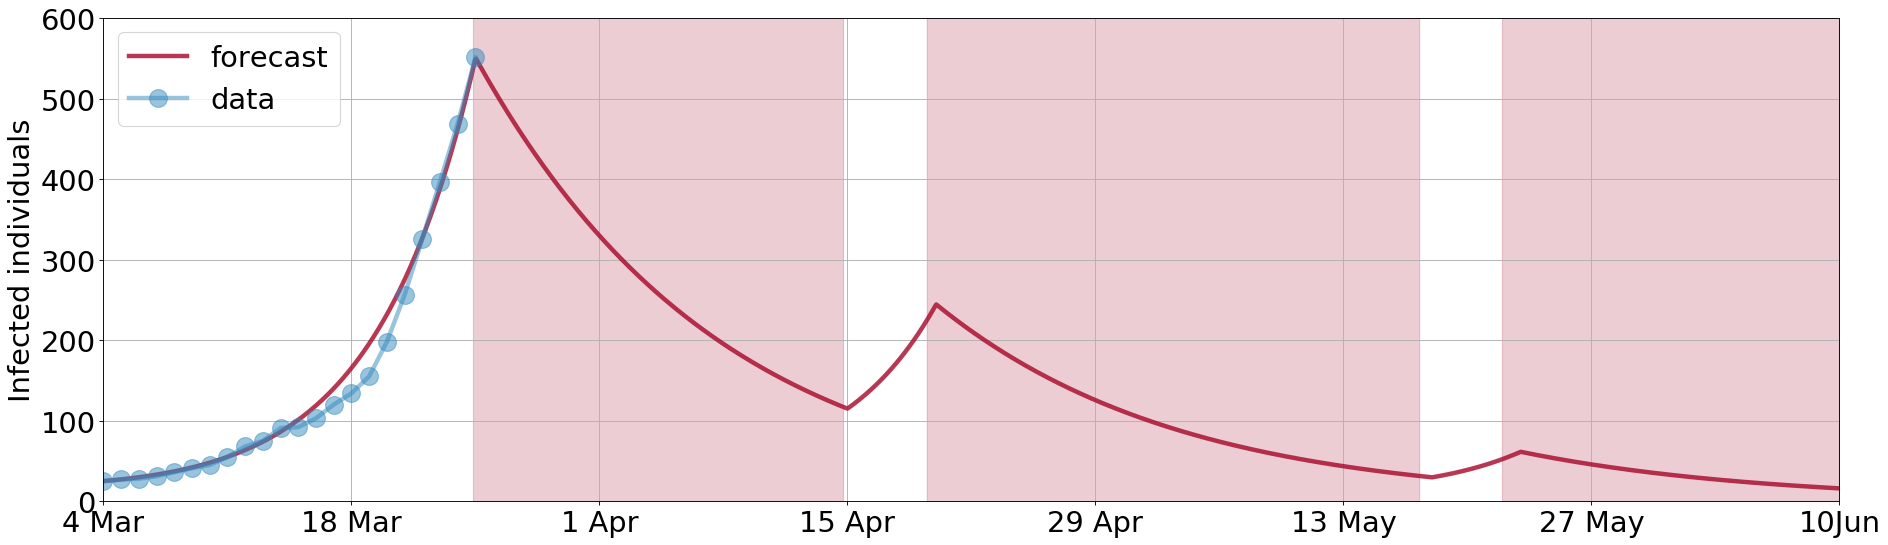

In [12]:
IC  = np.zeros((Nf))
SC  = np.zeros((Nf))

for i in range(M):
        IC += data['X'][:,2*M+i] 
        SC += data['X'][:,0*M+i] 
t = data['t']; t1=int(Nf/(14))




fig=plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));

plt.fill_between(t[3*t1:6*t1], 0, 600, color="#A60628", alpha=0.2)
plt.fill_between(t[6*t1+96:10*t1+96], 0, 600, color="#A60628", alpha=0.2)
plt.fill_between(t[10*t1+190:], 0, 600, color="#A60628", alpha=0.2)


my_data = np.genfromtxt('../data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,3] - my_data[:,1]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, Tf); plt.ylim(0, 600);
plt.savefig('/Users/rsingh/Desktop/4b.png', format='png', dpi=200)

In [13]:
MM = np.array((0,0,.0,1,1,1,1,1,1,3.5,3.5,3.5,3.5,6,6,14.2))  
## Fatality Rate by AGE per 100 cases https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/
m1 = .01*MM*(data['X'][430,0:M]-data['X'][-1,0:M])
np.sum(m1)


11.897389217119663

### One long closure

In [14]:
def contactMatrix(t):
    if t<21:
        xx = C
    elif 21<=t<70:
        xx = CH
    else:
        xx = C
    return xx


# start simulation
Tf=70;  Nf=2000;  
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

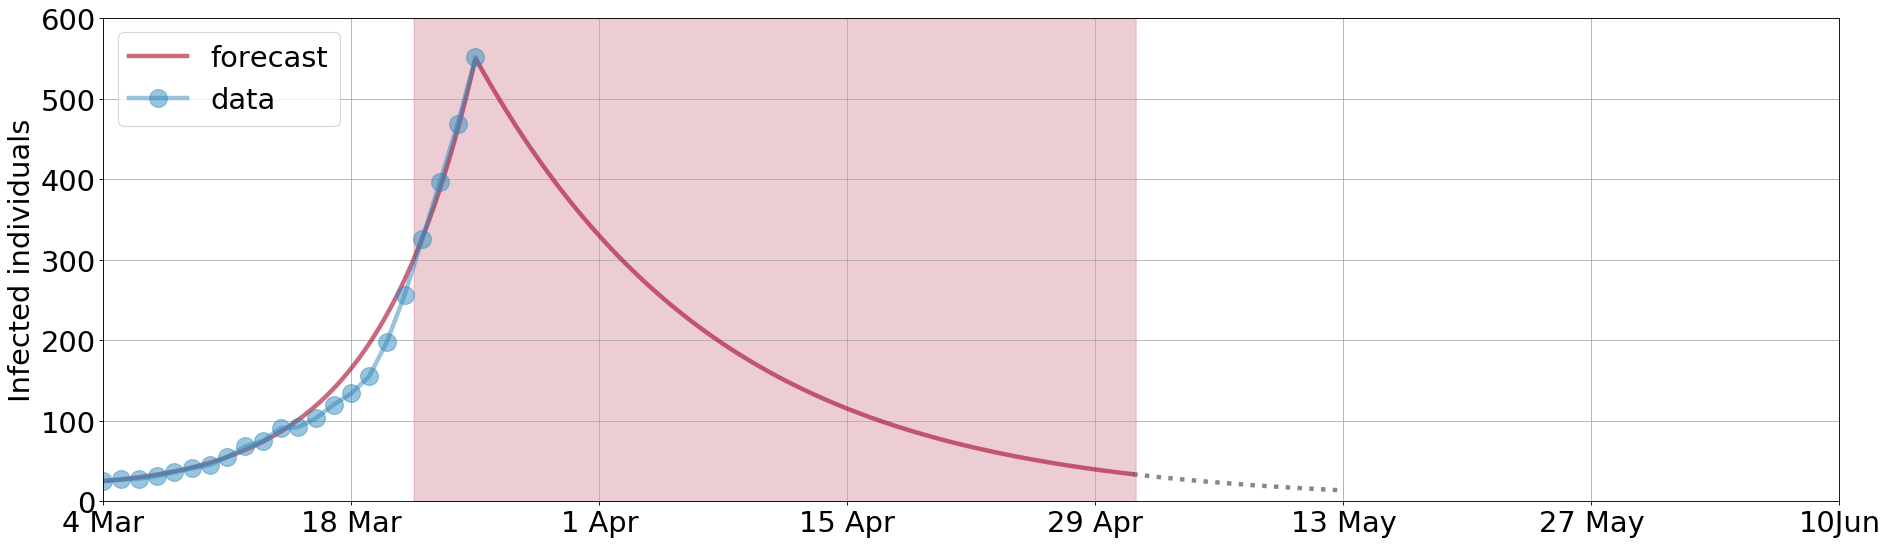

In [15]:
IC  = np.zeros((Nf))
SC  = np.zeros((Nf))

for i in range(M):
        IC += data['X'][:,2*M+i] 
        SC += data['X'][:,0*M+i] 

t = data['t']; t1=int(Nf/(12))
fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t[0:10*t1], IC[0:10*t1], '-', lw=4, color='#A60628', label='forecast', alpha=0.6)

plt.plot(t[10*t1:], IC[10*t1:], ':', lw=4, color='dimgrey', alpha=0.8)

plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));

plt.fill_between(t[3*t1+2:10*t1+5], 0, 600, color="#A60628", alpha=0.2)
#plt.fill_between(t[10*t1+10:14*t1+70], 0, 600, color="#A60628", alpha=0.2)

my_data = np.genfromtxt('../data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,3]- my_data[:,1]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 

plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.ylim(0, 600); plt.xlim(0, 98);
plt.savefig('/Users/rsingh/Desktop/4d.png', format='png', dpi=200)
#IC[-1]

In [16]:
MM = np.array((0,0,.0,1,1,1,1,1,1,3.5,3.5,3.5,3.5,6,6,14.2))  
## Fatality Rate by AGE per 100 cases https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/
m1 = .01*MM*(data['X'][600,0:M]-data['X'][-1,0:M])
np.sum(m1)

6.719995478939264

In [17]:
np.size(t)

2000

In [18]:
t[600]

21.010505252626313